In [1]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 35.0 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from tqdm import tqdm    #interactive progress meter
import random
import matplotlib.pyplot as plt
import torch
from rasterio.enums import Compression

In [3]:
patch_size = 256
stride = 128
image_path = '/content/drive/MyDrive/FirstDeepLearningProject/Input.tif'
mask_path = '/content/drive/MyDrive/FirstDeepLearningProject/BarLabel.tif'
out_img_dir = '/content/drive/MyDrive/FirstDeepLearningProject/7band_images_npy'
out_mask_dir = '/content/drive/MyDrive/FirstDeepLearningProject/7band_label_npy'
save_as = 'npy'

In [9]:
output_path = '/content/drive/MyDrive/FirstDeepLearningProject/Input_7band.tif'
band_to_remove = 6  # Index starts at 1 in rasterio

with rasterio.open(image_path) as src:
    original_descriptions = list(src.descriptions)
    meta = src.meta.copy()
    meta.update(count=src.count - 1)

    with rasterio.open(output_path, 'w', **meta) as dst:
        dst_band_idx = 1
        for i in range(1, src.count + 1):
            if i != band_to_remove:
                data = src.read(i)
                dst.write(data, dst_band_idx)
                # Set the original band name (skip the removed one)
                band_name = original_descriptions[i - 1]
                dst.set_band_description(dst_band_idx, band_name)
                dst_band_idx += 1
new_image_path = '/content/drive/MyDrive/FirstDeepLearningProject/Input_7band.tif'

In [5]:
os.makedirs(out_img_dir,exist_ok = True)
os.makedirs(out_mask_dir,exist_ok = True)

In [10]:
with rasterio.open(new_image_path) as src:
  print(src.count)
  print(src.descriptions)


7
('B2', 'B3', 'B4', 'B8', 'VV', 'NDVI', 'NDWI')


In [11]:
def save_patch(arr,meta,out_path):
  if save_as == 'npy':
    np.save(out_path,arr)
  else :
    with rasterio.open(out_path,w,**meta) as dst:
      dst.write(arr)

with rasterio.open(new_image_path) as img_src,rasterio.open(mask_path) as mask_src:
  img_meta = img_src.meta
  mask_meta = mask_src.meta
  h,w = img_src.height,img_src.width
  patch_id = 1

  for i in range(0,h-patch_size+1,stride):
    for j in range(0,w-patch_size+1,stride):
      window = Window(j,i,patch_size,patch_size)

      img_patch = img_src.read(window =window)
      mask_patch = mask_src.read(window = window)

      filename = f'{patch_id:05d}'
      img_out_path = os.path.join(out_img_dir,filename + ('.tif' if save_as  == 'tif' else '.npy'))
      mask_out_path = os.path.join(out_mask_dir,filename +('.tif' if save_as == 'tif' else '.npy'))

      if save_as == 'tif':
        img_meta.update({
            'height' : patch_size,
            'width' : patch_size,
            'transform' : rasterio.windows.transform(window,img_src.transform)
        })

        mask_meta.update({
            'height': patch_size,
            'width' : patch_size,
            'transform' : rasterio.windows.transform(window,mask_src.transform)
        })


      save_patch(img_patch,img_meta,img_out_path)
      save_patch(mask_patch,mask_meta,mask_out_path)

      patch_id += 1


print("✅ Patching complete with for Images and Mask ")




✅ Patching complete with for Images and Mask 


In [12]:
input_dir = '/content/drive/MyDrive/FirstDeepLearningProject/7band_images_npy'
output_dir = '/content/drive/MyDrive/FirstDeepLearningProject/7band_images_npy_normalized'
os.makedirs(output_dir, exist_ok=True)

optical_idx = [0,1,2]
sar_idx = [3,4]
ni = [5,6]

def normalized_optical(band):
  return band/255

def normalized_sar(band):
  b_min,b_max = band.min(),band.max()
  return (band-b_min)/(b_max-b_min + 1e-8)

def normalized_ni(band):
  return(band+1)/2

for fname in sorted(os.listdir(input_dir)) :
  if not fname.endswith('.npy'):
    continue

  img = np.load(os.path.join(input_dir,fname)).astype(np.float32)
  norm_img = np.empty_like(img,dtype = np.float32)
  for idx in optical_idx:
    norm_img[idx] = normalized_optical(img[idx])
  for idx in sar_idx:
    norm_img[idx] = normalized_sar(img[idx])
  for idx in ni:
    norm_img[idx] = normalized_ni(img[idx])

  np.save(os.path.join(output_dir,fname),norm_img)


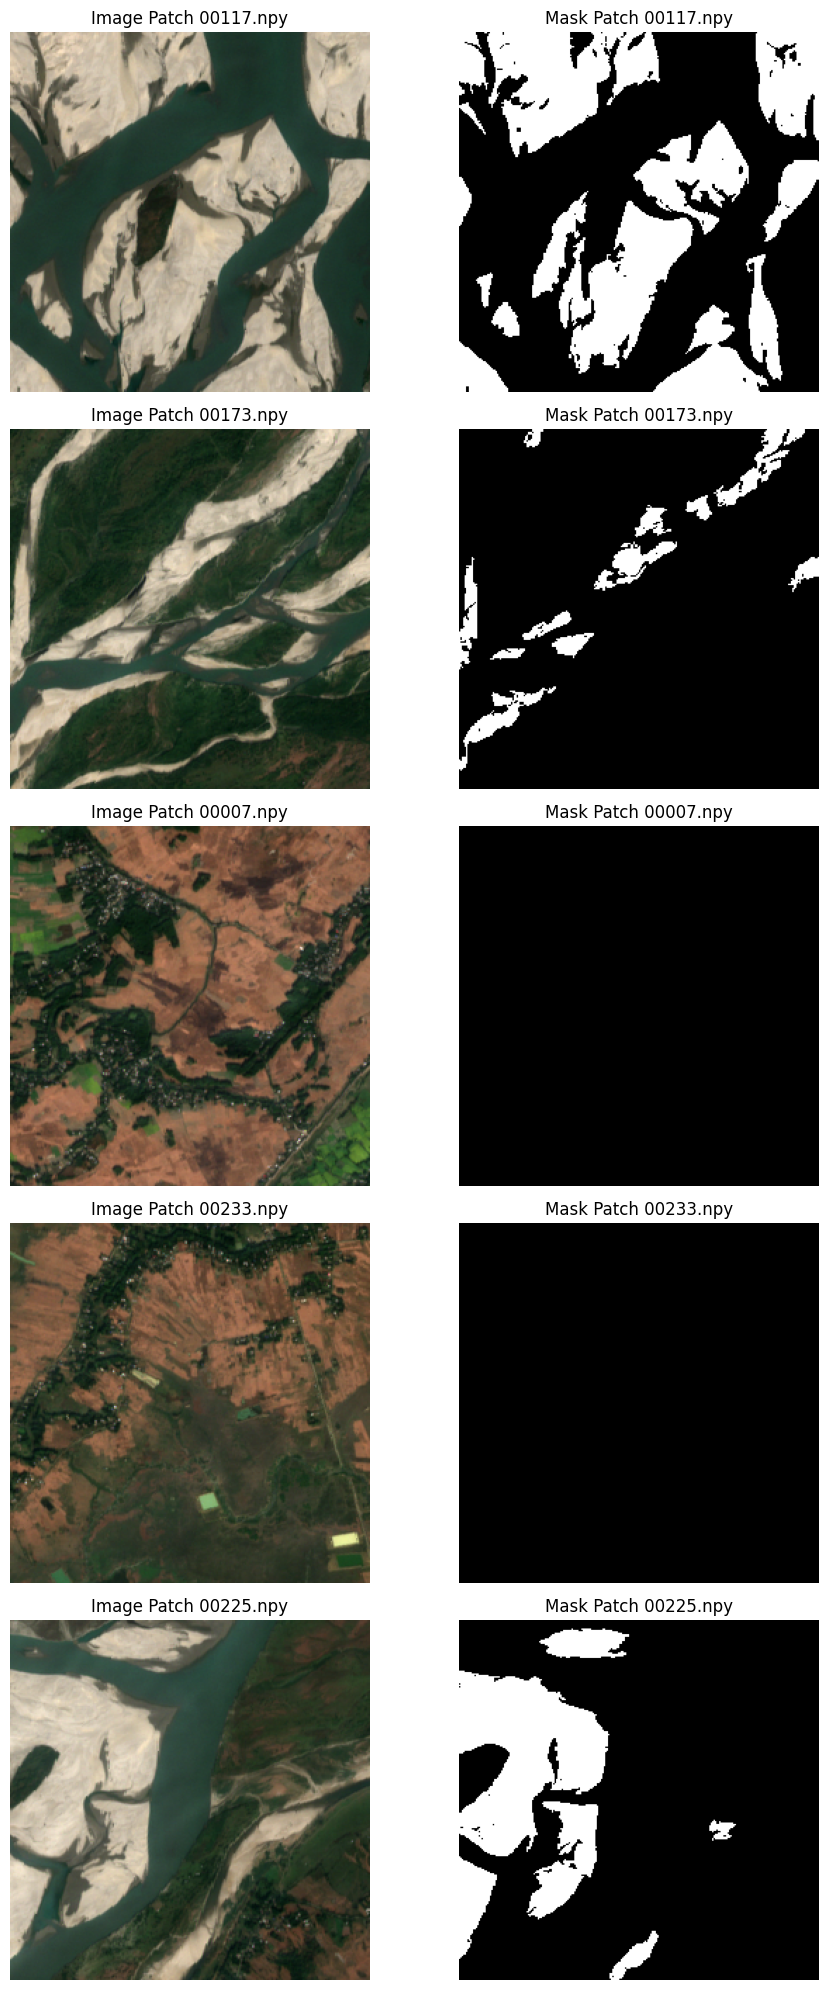

In [14]:

# ==== Folder paths ====
img_dir = '/content/drive/MyDrive/FirstDeepLearningProject/7band_images_npy_normalized'
mask_dir = '/content/drive/MyDrive/FirstDeepLearningProject/label_npy'

#  ==== Get all patch file names ====
all_patches = sorted([ f for f in os.listdir(img_dir) if f.endswith('.npy')])
random_patches = random.sample(all_patches, 5)

# ==== Function to normalize and get RGB ====
def get_rgb(img_patch):
    rgb = np.stack([
        img_patch[2],  # R
        img_patch[1],  # G
        img_patch[0]   # B
    ], axis=-1)
    rgb = rgb.astype(np.float32)
    rgb -= rgb.min()
    rgb /= rgb.max() + 1e-8
    return rgb

# ==== Plot ====
fig, axs = plt.subplots(5, 2, figsize=(10, 20))

for i, filename in enumerate(random_patches):
    # Load image and mask
    image_patch = np.load(os.path.join(img_dir, filename))
    mask_patch = np.load(os.path.join(mask_dir, filename))

    rgb_patch = get_rgb(image_patch)
    mask_patch = mask_patch.squeeze()

    # Plot image
    axs[i, 0].imshow(rgb_patch)
    axs[i, 0].set_title(f"Image Patch {filename}")
    axs[i, 0].axis('off')

    # Plot mask
    axs[i, 1].imshow(mask_patch, cmap='gray')
    axs[i, 1].set_title(f"Mask Patch {filename}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()